# Checking Datasets

**Author: Shahzad Sanjrani**

**Date: 21.11.24**

Notebook to just sanity check the input of the h5 input/output.

In [21]:
import h5py
import numpy as np
import os
import mplhep as hep
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt

In [105]:
store_dir = "/nfs/dust/cms/user/sanjrani/SPANet_Investigations/investigation2/pepper_analysis/output/h4t_systematics/spanet"

# infile = "input/genstudies_2017_jpt20_GENRECO_training/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/TTTT_TuneCP5_13TeV-amcatnlo-pythia8_even_train.h5"
infile = "input/genstudies_2017_jpt20_GENRECO_training/TTZprimeToTT_M-500_Width4_TuneCP5_13TeV-madgraph-pythia8/TTZprimeToTT_M-500_Width4_TuneCP5_13TeV-madgraph-pythia8_even_train.h5"

### What do we want to check?

Some of the jet distributions.

Some of the assignment percentages.

In [18]:
def plot_hepfig(figsize=(10,10)):
    ''' plt.figure but use the mplhep package to make it look nice '''
    hep.style.use("CMS")
    mpl.rcParams["font.size"] = 20
    plt.figure(figsize=figsize)

In [60]:
def get_order_of_mag(min_value, counter_max = 10):
    order_of_mag = 1
    counter = 0
    while order_of_mag > min_value:
        order_of_mag = order_of_mag / 10
        counter += 1
        if counter > counter_max:
            break
    return order_of_mag

In [88]:
def get_ymin(counts, density=False, yscale='linear'):
    ymin = 0
    if yscale == 'log' or density == True:
        ymin = 1
        if np.min(counts) < ymin:
            ymin = get_order_of_mag(np.min(counts))

In [85]:
def plot_input(input_key, input_attribute, file, bins=None, yscale='linear'):

    try:
        inarray_mask = ak.Array(file[f"INPUTS/{input_key}/MASK"])
    except:
        inarray_mask = None

    inarray = ak.Array(file[f"INPUTS/{input_key}/{input_attribute}"])
    if inarray_mask is not None:
        inarray = inarray[inarray_mask]

    plot_hepfig()
    if bins is None:
        # default is printing 10 bins between min and max
        bins = np.linspace(np.min(inarray), np.max(inarray), 10)
        
    counts, _, _ = plt.hist(ak.flatten(inarray), bins=bins, label=f"{input_key}:{input_attribute}")
    plt.yscale(yscale)
    plt.xlim((bins[0],bins[-1]))
    plt.ylim((0, np.max(counts)*1.35))
    plt.xlabel(f"N. {input_key}")
    plt.ylabel(f"{input_attribute}")

    return None
    

In [110]:
def resonance_checks(resonance_reco, resonance_keys, label=None):
    '''
    Plot fraction of events of how many events where N res in res_keys are reconstructed
    '''
    res_reco = np.array( [resonance_reco[res] for res in resonance_keys] )
    res_n = np.sum(res_reco.astype(int), axis=0)
    plot_hepfig()

    yscale, density, bins = 'linear', True, np.arange(0, len(resonance_keys)+2)
    counts, _, _ = plt.hist( res_n, bins=bins, density=density, label=label)
    ymin = get_ymin(counts, density=density, yscale=yscale)
    plt.ylim((ymin, np.max(counts)*1.35))
    plt.xlim((bins[0], bins[-1]))
    plt.xlabel(f"N. reconstructable")
    plt.ylabel(f"Fraction of events")
    plt.yscale(yscale)
    plt.legend()


def plot_targets(file, tttt_checks=True, yscale='linear'):
    '''
    assumes we have the following: (cba to generalise)
    - {'ti':['q1','q2','b'], ..} for i in [1,2,3,4]
    - {'zpti':['q1','q2','b'], 'nzpti':['q1','q2','b'],..} for i in [1,2]
    '''
    resonance_keys = {}
    for k in list(file["TARGETS"].keys()):
        resonance_keys[k] = list(file[f"TARGETS/{k}"].keys())

    # generalised
    resonance_reco = {}
    for resonance in resonance_keys:
        daughters = np.array([ file[f"TARGETS/{resonance}/{daughter}"] for daughter in resonance_keys[resonance] ])
        reco = np.all( daughters >= 0, axis = 0)
        resonance_reco[resonance] = reco

    plot_hepfig()
    x_pos, x_labels = np.arange(0,len(list(resonance_reco.keys())))+0.5, list(resonance_reco.keys())
    heights = [ np.sum(resonance_reco[k]) for k in resonance_keys ]
    
    plt.bar(x_pos, heights, width=0.5, tick_label=x_labels)
    plt.ylim((0, np.max(heights)*1.35))
    plt.xlabel(f"Top")
    plt.ylabel(f"N. reconstructable")

    if tttt_checks:

        # check how many hnt
        tops = ['t1','t2','t3','t4']
        resonance_checks(resonance_reco, resonance_keys=tops, label='SM tops')

        # check how many hnt (zp)
        tops = ['zpt1','zpt2','nzpt1','nzpt2']
        resonance_checks(resonance_reco, resonance_keys=tops, label='Zp, non-Zp tops')

        # check how many zp tt
        tops = ['zpt1','zpt2']
        resonance_checks(resonance_reco, resonance_keys=tops, label='Zp tops')

        # check how many non z' tt
        tops = ['nzpt1','nzpt2']
        resonance_checks(resonance_reco, resonance_keys=tops, label='non-Zp tops')

## Make your checks here

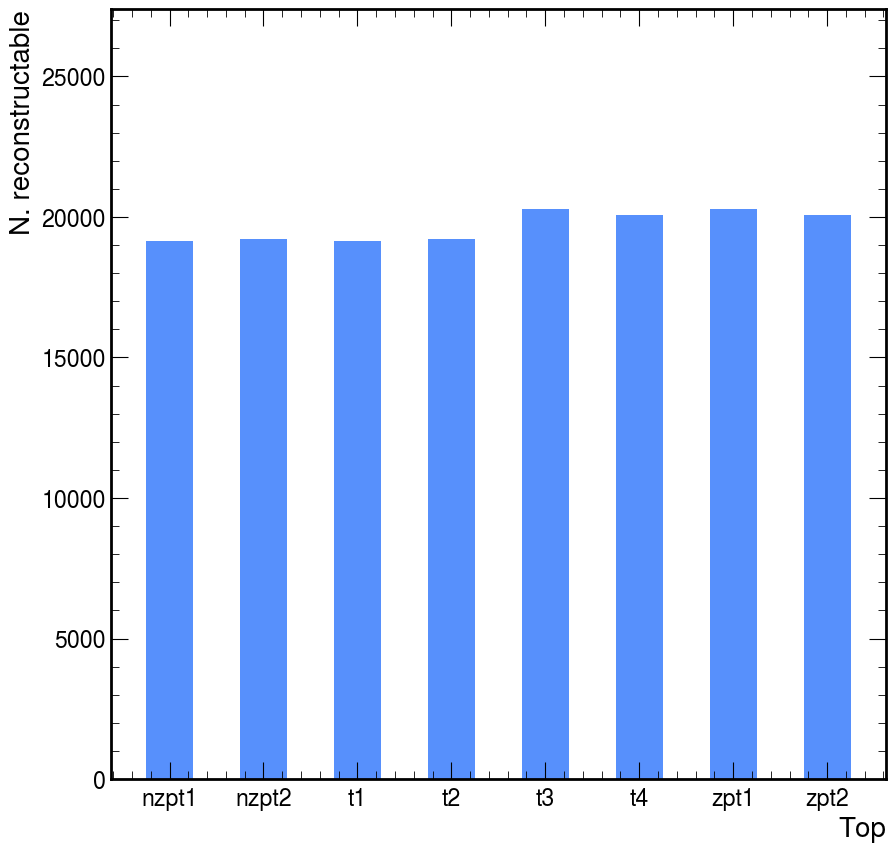

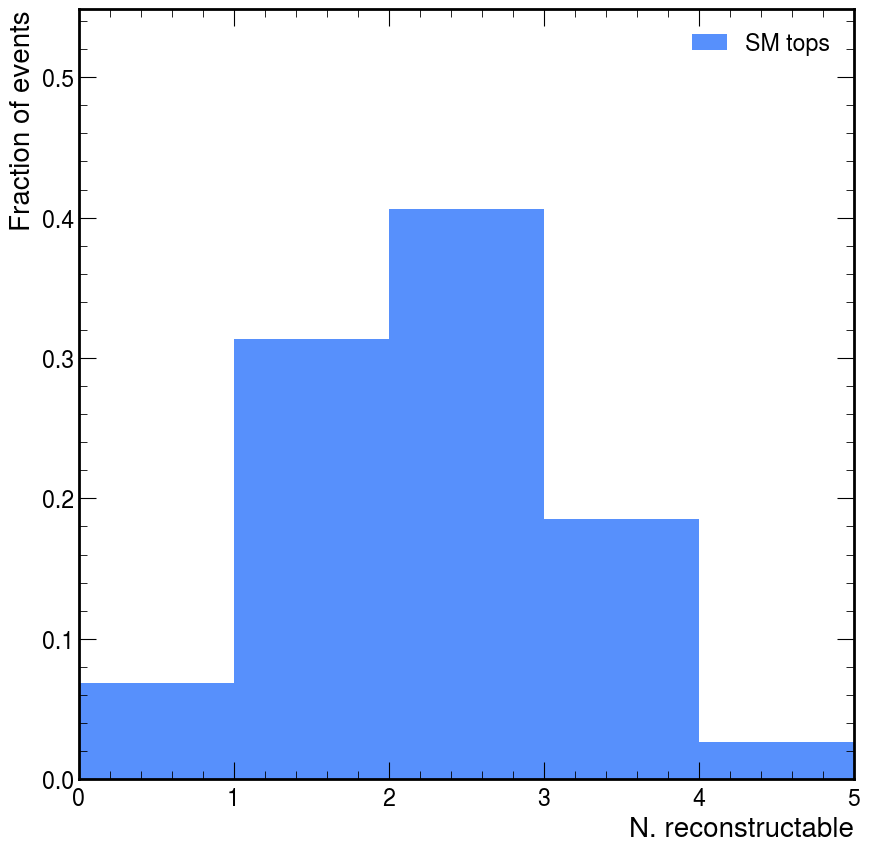

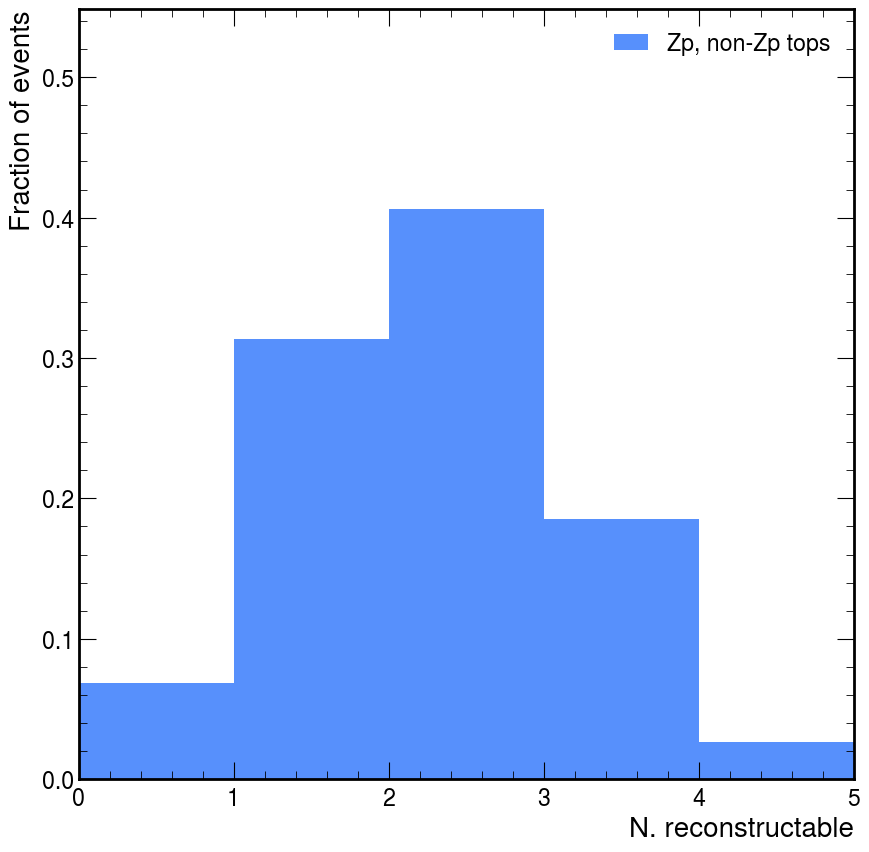

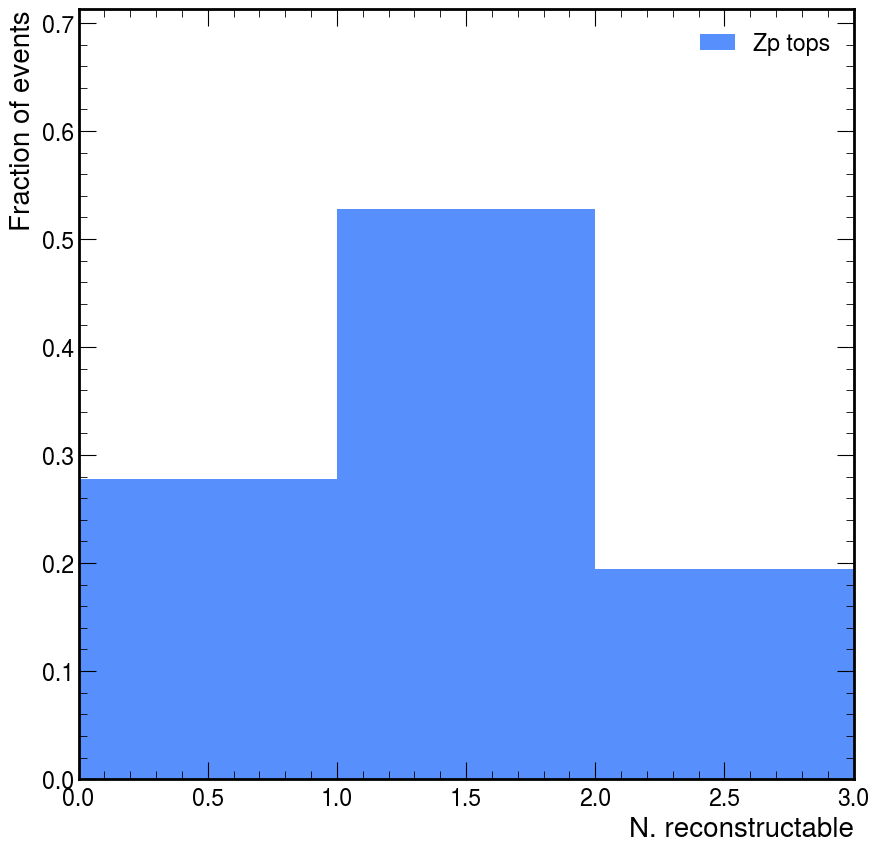

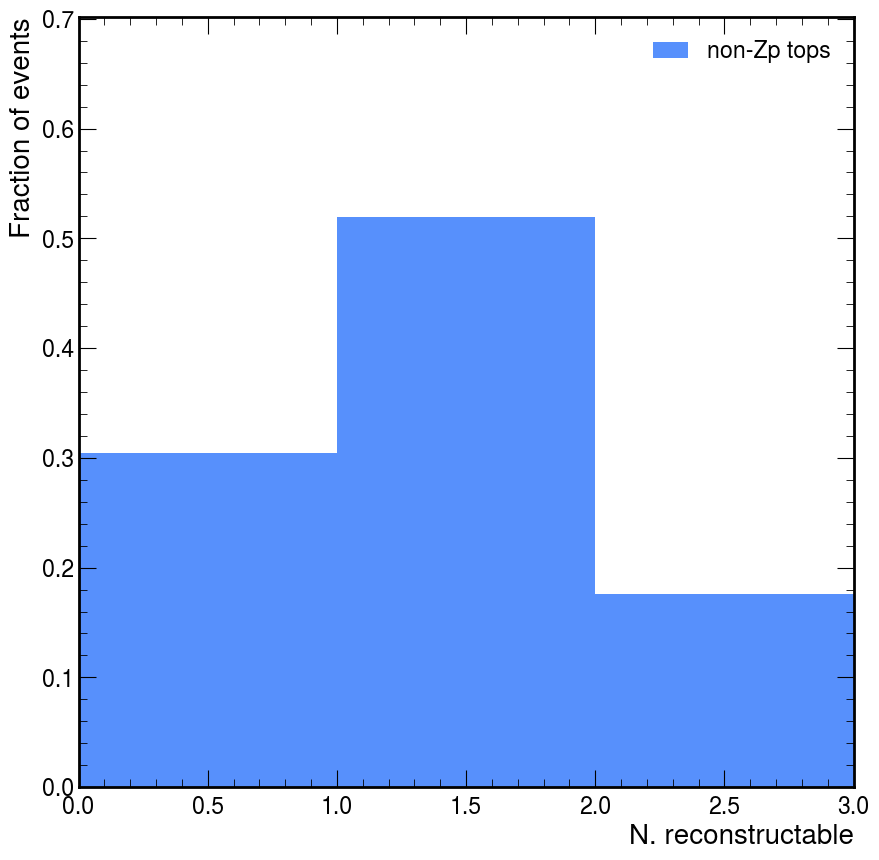

In [111]:
with h5py.File(os.path.join(store_dir, infile), "r") as file:

    # plot_input("Jets", "pt", file)
    plot_targets(file, tttt_checks=True)